Додати оптимізацію градієнтного спуску mini-batch.

In [1]:
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#BC371B', '#BC881B', '#4FBC1B'])
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright)

In [3]:
class NeuralNet:
    """
    NN for multi-class classification with mini-batch
    Attributes:
    ...
    """
    
    def __init__(self, mbgd_size, neurons_in_layers, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.mbgd_size = mbgd_size
        self.neurons_in_layers = neurons_in_layers
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s
    
    def __softmax(self, Z):
        eZ = np.exp(Z - np.max(Z))
        return eZ / np.sum(eZ, axis=0, keepdims=True)

    def __initialize_parameters(self):
        neurons_in_layers = self.neurons_in_layers
        parameters = {}
        for i in range(1, len(neurons_in_layers)):
            parameters["W" + str(i)] = np.random.randn(neurons_in_layers[i], neurons_in_layers[i - 1]) * np.sqrt(1 / neurons_in_layers[i - 1])
            parameters["b" + str(i)] = np.zeros((neurons_in_layers[i], 1))
        self.parameters = parameters
       
    def __forward_propagation(self, X):
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2

        for i in range(1, L):
            prev_A = A
            W = parameters["W"+str(i)]
            b = parameters["b"+str(i)]
            
            Z = np.dot(W, prev_A) + b
            linear_cache = (prev_A, W, b)
            
            A = self.__softmax(Z)
            activation_cache = Z
            
            cache = (linear_cache, activation_cache)            
            caches.append(cache)   
            
        W = parameters["W"+str(L)]
        b = parameters["b"+str(L)]
        
        Z = np.dot(W, A) + b
        linear_cache = (A, W, b)
            
        AL = self.__softmax(Z)
        activation_cache = Z
            
        cache = (linear_cache, activation_cache)            
        caches.append(cache)  
        
        return AL, caches
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
        
    def __backward_propagation(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        linear_cache, activation_cache = caches[L-1]
        Z = activation_cache
        s = self.__softmax(Z)
        dZ = dAL * s * (1 - s)
        prev_A, W, b = linear_cache
        m = prev_A.shape[1]
        dW = 1 / m * np.dot(dZ, prev_A.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prev_dA = np.dot(W.T, dZ)
        
        grads["dA" + str(L-1)] = prev_dA
        grads["dW" + str(L)] = dW
        grads["db" + str(L)] = db
        
        for i in reversed(range(L-1)):
            linear_cache, activation_cache = caches[i]
            Z = activation_cache
            s = self.__softmax(Z)
            dZ = prev_dA * s * (1 - s)
            prev_A, W, b = linear_cache
            m = prev_A.shape[1]
            dW = 1 / m * np.dot(dZ, prev_A.T)
            db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
            prev_dA = np.dot(W.T, dZ)
            
            grads["dA" + str(i)] = prev_dA
            grads["dW" + str(i + 1)] = dW
            grads["db" + str(i + 1)] = db
        return grads
   
    def __update_parameters(self, grads):
        parameters = self.parameters
        learning_rate = self.learning_rate

        for i in range(len(parameters) // 2):
            parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - learning_rate * grads["dW" + str(i+1)]
            parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - learning_rate * grads["db" + str(i+1)]
            
        self.parameters = parameters
        
    def __shuffle_and_separate(self, X, Y):            
        m = X.shape[1]
        SS_data = [] #for shuffled and separated data
        mbgd_size = self.mbgd_size
        
        perm = list(np.random.permutation(m))
        shuff_X = X[:, perm]        
        shuff_Y = Y[:, perm]

        for i in range(0, int(np.floor(m/mbgd_size))):
            batch_X = shuff_X[:, i*mbgd_size : (i + 1)*mbgd_size]
            batch_Y = shuff_Y[:, i*mbgd_size : (i + 1)*mbgd_size]
            
            batch = (batch_X, batch_Y)
            SS_data.append(batch)

        if m % mbgd_size != 0:
            batch_X = shuff_X[:, int(np.floor(m/mbgd_size))*mbgd_size:]
            batch_Y = shuff_Y[:, int(np.floor(m/mbgd_size))*mbgd_size:]
            
            batch = (batch_X, batch_Y)
            SS_data.append(batch)

        return SS_data
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        m = X.shape[1]
        costs = []
        
        self.__initialize_parameters()

        for i in range(0, self.num_iter):
            SS_data = self.__shuffle_and_separate(X, Y)
            
            for (batch_X, batch_Y) in SS_data:
                A, caches = self.__forward_propagation(batch_X)

                cost = self.compute_cost(A, batch_Y)

                grads = self.__backward_propagation(A, batch_Y, caches)

                self.__update_parameters(grads)
            
            costs.append(cost)

            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 100 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        return np.argmax(positive_probs, axis = 1)


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [4]:
iris = load_iris()
X = iris.data
Y = iris.target

print('Dataset: X={}, y={}'.format(X.shape, Y.shape))

Dataset: X=(150, 4), y=(150,)


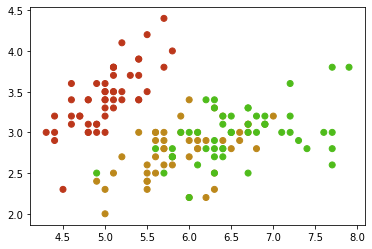

In [5]:
plot_data(X, Y)

In [6]:
cls = NeuralNet(mbgd_size = 1024, neurons_in_layers = [4, 15, 3], normalize = True, learning_rate = 0.1, num_iter = 2000)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=10)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [8]:
Y_train_transf = np.zeros([len(Y_train), 3])
for i in range(0, len(Y_train)):
    for j in range(0, 3):
        if Y_train[i] == j:
            Y_train_transf[i][j] = 1

Y_train_transf

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1

0-th iteration: 0.3654264938989841
100-th iteration: 0.27456438123169347
200-th iteration: 0.20142393397994596
300-th iteration: 0.16810145465458984
400-th iteration: 0.15135777355287144
500-th iteration: 0.13995806243077508
600-th iteration: 0.1292601082390573
700-th iteration: 0.1170740251627617
800-th iteration: 0.10490675557471084
900-th iteration: 0.09447305223111574
1000-th iteration: 0.08471936137136485
1100-th iteration: 0.07636282653815855
1200-th iteration: 0.06951254700210446
1300-th iteration: 0.0635319873223483
1400-th iteration: 0.05652075903311395
1500-th iteration: 0.04646163483014174
1600-th iteration: 0.04272212705116011
1700-th iteration: 0.040179209938472946
1800-th iteration: 0.03818522790085597
1900-th iteration: 0.036549655358775565


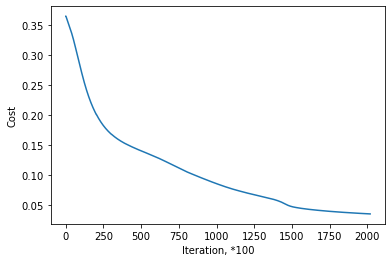

In [9]:
cls.fit(X_train, Y_train_transf)

In [10]:
print(cls.parameters)

{'W1': array([[-2.68669161e-01,  1.68688635e-01, -4.11877983e-01,
         9.00808790e-03],
       [ 4.18176465e-02, -2.58074365e-01, -9.56937259e-01,
        -5.53167611e-01],
       [ 7.98038750e-01,  6.46456428e-01, -5.04469599e-01,
         1.03205202e+00],
       [ 1.50980894e-01, -7.17721330e-02, -2.74261583e-01,
        -4.41739594e-02],
       [ 5.45814311e-02,  2.34945894e-01, -1.84237454e-01,
         2.92009257e-01],
       [ 4.39633131e-01, -1.58764195e+00,  3.69709124e-01,
         9.93377579e-01],
       [ 5.08313913e-01, -2.53793255e-01, -9.06851247e-01,
        -3.44331317e-02],
       [ 7.08017165e-01,  1.28000035e-01, -5.87095982e-05,
         5.25107206e-02],
       [ 1.39464750e+00, -1.61769050e+00,  6.53920302e-01,
         3.38697739e-01],
       [ 4.32770633e-01,  3.99794645e-01,  3.25422714e-01,
        -6.81569150e-01],
       [-2.18987677e-01,  2.13025688e-01, -2.17308626e-01,
        -5.70686118e-01],
       [-1.31499672e+00,  3.21174504e-01, -1.50090225e+00,

In [11]:
Y_prob = cls.predict_proba(X_train)
Y_prob

array([[0.00733884, 0.96528521, 0.02737594],
       [0.00796886, 0.96689739, 0.02513375],
       [0.01210767, 0.30096935, 0.68692298],
       [0.00196868, 0.01213538, 0.98589594],
       [0.00322825, 0.02758435, 0.9691874 ],
       [0.9872807 , 0.00924112, 0.00347819],
       [0.00379212, 0.02875451, 0.96745337],
       [0.00214137, 0.01371336, 0.98414527],
       [0.0018759 , 0.01128072, 0.98684339],
       [0.00217623, 0.01423791, 0.98358585],
       [0.9865864 , 0.0097682 , 0.0036454 ],
       [0.98574411, 0.01040697, 0.00384893],
       [0.01324904, 0.92951268, 0.05723828],
       [0.93699337, 0.05226274, 0.0107439 ],
       [0.04533338, 0.78706043, 0.16760619],
       [0.98738619, 0.00915953, 0.00345428],
       [0.013656  , 0.86633473, 0.12000927],
       [0.02777503, 0.42167793, 0.55054703],
       [0.00336315, 0.02820742, 0.96842944],
       [0.00205285, 0.01257394, 0.9853732 ],
       [0.01414689, 0.45669594, 0.52915718],
       [0.00564752, 0.03679799, 0.95755449],
       [0.

In [12]:
Y_train_hat = cls.predict(X_train)
Y_train_hat

array([1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 2, 2, 2, 2,
       1, 1, 1, 0, 0, 1, 0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 1, 2, 0, 2, 1, 2,
       2, 1, 0, 1, 2, 1, 0, 2, 1, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 2, 2,
       1, 1, 2, 2, 2, 1, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       2, 0, 1, 1, 2, 0, 2, 0, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 0,
       0, 1, 0, 2, 2, 2, 1, 0, 2, 0], dtype=int64)

In [13]:
accuracy_score(Y_train, Y_train_hat)

0.9416666666666667

In [14]:
Y_test_hat = cls.predict(X_test)
Y_test_hat

array([1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2,
       2, 0, 1, 0, 1, 1, 1, 2], dtype=int64)

In [15]:
accuracy_score(Y_test, Y_test_hat)

1.0